# Refining Ratings: A Detailed Approach to Predicting Restaurant Star Ratings From Key Attributes
### Group: Siddhi Bansal, Isha Kalanee, Ishita Kumari, Akshat Shah

Our goal is to train a machine-learning model that predicts a restaurant’s star rating based on specific restaurant attributes (total_open_hours, RestaurantsTakeOut, RestaurantsDelivery, Alcohol). This model can potentially be used by new restaurant businesses to predict their star rating (as a measure of success) using the specific features required by the model.

In [1]:
# Standard library imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import timedelta

### I. Data Preparation
Our original dataset contains 150,346 entries of businesses recorded on Yelp, each record containing attributes such as ‘name’, ‘address’, ‘latitude’, ‘longitude’, ‘review_count’, and ‘stars’. Since we want our model to focus on predicting the success of restaurants, we only keep the businesses that are labeled as ‘Restaurants’. Additionally, we drop the columns that are irrelevant and those that will bias/skew our models, such as ‘name’ and ‘business_id’. We are choosing to deal with NaNs by dropping all records with NaN values in the original dataset and further downsizing our dataset by dropping all businesses that are no longer open.

In [2]:
# Read the data file

df = pd.read_json('data/yelp_academic_dataset_business.json', lines=True)
print("Shape of the data frame:", df.shape)

Shape of the data frame: (150346, 14)


In [3]:
# Drop all records with missing values and irrelevant columns
df = df.dropna()
df = df.drop(columns=['name', 'address', 'city'])

print("Shape of the modified data frame:", df.shape)

Shape of the modified data frame: (117618, 11)


In [4]:
# Keep only businesses that are restaurants
df = df[df['categories'].str.contains('Restaurants')]

# Keep only businesses that are still open (not permanently closed)
df = df[df['is_open']==1]

# Drop the is_open column (irrelevant)
df = df.drop(columns='is_open')

print("Shape of the modified data frame:", df.shape)

Shape of the modified data frame: (31357, 10)


In [5]:
# Parse JSON data in attributes and hours columns to individual feature columns

df = df.join(pd.json_normalize(df['attributes']))
df = df.join(pd.json_normalize(df['hours']))

# Drop the attributes and hours columns containing JSON data
df = df.drop(columns=['attributes', 'hours'])

### II. Data Exploration

We searched for correlations between various combinations of the remaining attributes. Eventually, we visualized the locations of the restaurants on a Cartesian plane by latitude (horizontal axis) and longitude (vertical axis), features of the original dataset. An important observation we made is that the data included information about the business’s daily hours. Another is determining how many missing values each feature had. This is critical to choose which columns to remove (to also reduce dimensionality) and maintain a dataset good enough for our training purposes. There were quite a few missing values in many of the columns created (from the attributes column) during data preparation since the data was initially unstructured JSON.

TODO visuals?

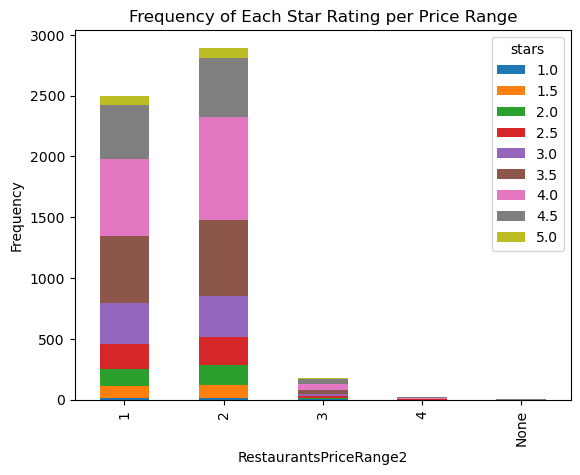

In [7]:
import matplotlib.pyplot as plt

# Searching for any correlation between the Price Range attribute (categorical from 1-4) and 'stars'

# Plotting the grouped DataFrame as a bar plot
grouped_df = df.groupby(['RestaurantsPriceRange2', 'stars']).size().unstack(fill_value=0)
grouped_df.plot(kind='bar', stacked=True)
plt.xlabel('RestaurantsPriceRange2')
plt.ylabel('Frequency')
plt.title('Frequency of Each Star Rating per Price Range')
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler

location_df = df[['latitude', 'longitude', 'stars']]

stars = location_df['stars']
location_df = location_df.drop(columns='stars')

/Users/akshatshah/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0, 0.5, 'Longitude')

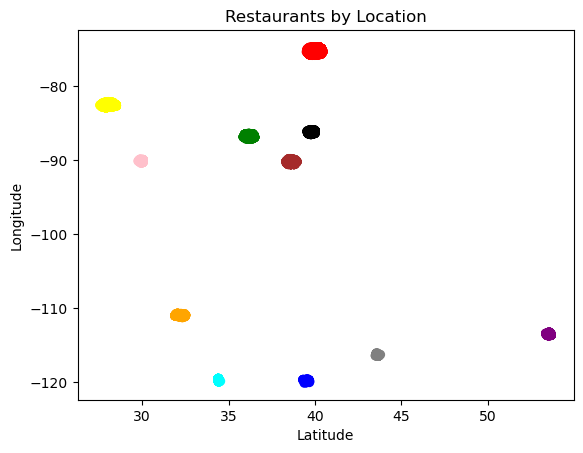

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=11)

kmeans.fit(location_df)

location_df['cluster'] = kmeans.predict(location_df)

colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'black', 'gray', 'cyan']

plt.scatter(location_df['latitude'], location_df['longitude'], c=location_df['cluster'].apply(lambda x: colors[x]))
plt.title("Restaurants by Location")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

### III. Feature Engineering
After exploring the data, we sought to create a final dataframe by modifying or aggregating certain features and leveraging the stacking technique to create an ensemble.

We started by creating our own function to parse each day’s hours. While the hours were in 24-hour format, there were some inconsistencies within the data. We made a few basic assumptions such as the following which are accounted for in the code:

- Missing value indicates the restaurant is closed that day
- If the end time is past 23:59, it’s on the next day
- If the start and end times are the same (e.g. 0:0-0:0), then the restaurant is open for all 24 hours of that day

The parse_hours() function implements all of the above; we sum each day’s hours into one value, stored in the total_open_hours column as the total weekly hours. We also removed each day’s hours columns, reducing the dimensionality of the data.

Secondly, we simplify the alcohol column, which indicates what type of alcohol the restaurant serves, if any. We made some more basic assumptions in doing this, such as a missing value indicating no alcohol. To simplify the data, we converted all values to true and false, rather than the more specific categories such as beer_and_wine and full_bar.

The stacking that we added at this stage includes:
A KNN Regression model on our existing dataset: estimates the business’s average rating by finding the mean rating of its k-nearest neighbors. The successful location-based clustering from data exploration led us to believe that there tends to be a slight correlation between the relative location of a restaurant and its ratings. We decided that training our model with this additional column could help improve accuracy.
A Decision Tree Regressor: predicts the number of stars based on stack 1 and the current four attributes: total_open_hours, RestaurantsTakeOut, RestaurantsDelivery, and Alcohol, with ‘stars’ as the label class.

Lastly, we imputed any missing values in our 3 boolean features as False. 

- Weekly hours open – sum of hours for each day
- Broader categories for alcohol – multiple classes to just true/false (boolean)
- Stacking
  - For each restaurant, use KNN to find k nearest restaurants and compute their average rating → add as feature into dataframe
  - For each restaurant, use a Decision Tree Regressor to predict the number of stars based on four features (total_open_hours, RestaurantsTakeOut, RestaurantsDelivery, Alcohol) and the label as stars (since this is a supervised algorithm)

Our final dataframe contains the following features:
- RestaurantsTakeOut - True if the Restaurant offers takeout, False otherwise
- RestaurantsDelivery - True if the Restaurant offers delivery, False otherwise
- Alcohol - True if the Restaurant serves alcohol, False otherwise
- total_open_hours - The total number of hours the restaurant is open every week
- stack_1 - Star predictions using a KNN Regression Model
- stack_2 - Star predictions using a Decision Tree Regressor

We use the ‘stars’ column as the label.

In [8]:
# Function to parse an hours string and return number of hours open
# e.g. 10:00-21:00 -> 11 hours

def parse_hours(day_hours_str):
    if pd.isna(day_hours_str):
        return 0
    
    time_endpoints = str(day_hours_str).split('-')

    if time_endpoints[0] == time_endpoints[1]:
        # 0:0-0:0
        return 24
    
    start_time = time.strptime(time_endpoints[0], "%H:%M")
    end_time = time.strptime(time_endpoints[1], "%H:%M")

    # account for edge cases in data where we have 10-1, which is technically 10am-1am
    et_hour = (24 + end_time.tm_hour) if end_time.tm_hour < start_time.tm_hour else end_time.tm_hour
    
    start_time_td = timedelta(hours=start_time.tm_hour, minutes=start_time.tm_min)
    end_time_td = timedelta(hours=et_hour, minutes=end_time.tm_min)

    duration = end_time_td - start_time_td

    return duration.total_seconds() / 3600

In [9]:
# Create new feature (total_open_hours) by combining all individual day hours

total_hours_arr = []
count_neg = 0
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for ind in df.index:
    total_hours = 0

    for day in days:
        day_hours_str = df[day][ind]
        day_hours = parse_hours(day_hours_str)
        total_hours += day_hours
    
    total_hours_arr.append(total_hours)

df['total_open_hours'] = total_hours_arr

# Drop all the individual day hours columns
df = df.drop(columns=days)

In [10]:
# Remove all features except a handful

df = df.filter(['total_open_hours', 'RestaurantsTakeOut', 'RestaurantsDelivery', 'Alcohol', 'latitude', 'longitude', 'stars'])

In [11]:
# Impute missing values with false

df['RestaurantsTakeOut'] = df['RestaurantsTakeOut'].fillna('False')
df['RestaurantsDelivery'] = df['RestaurantsDelivery'].fillna('False')
df['Alcohol'] = df['Alcohol'].fillna('False')

In [12]:
# Convert alcohol column to true/false values only

def alcohol_tf(val):
    if 'beer_and_wine' in val or 'full_bar' in val:
        return True
    else :
        return False

df['Alcohol_TF'] = df['Alcohol'].apply(alcohol_tf)

In [13]:
# Replace all 'None' values with False
df.replace('None', 'False', inplace=True)

# Convert all string representations of T/F to boolean values
df.replace({'True': True, 'False': False}, inplace=True)

# Drop alcohol feature (already feature engineered it)
df.drop(columns=['Alcohol'], inplace = True)

# Rename alcohol T/F feature column
df = df.rename(columns={'Alcohol_TF':'Alcohol'})

# Reset the index to 0, 1, ... - it changed after all the drops and modifications
df = df.reset_index()

In [14]:
# Apply KNN to find k nearest restaurants (by latitude/longitude)

# Create new feature (avg_star_rating) averaging the star rating of the k nearest restaurants

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Use location_df and stars DFs from data exploration
scaler = StandardScaler()
location_df = pd.DataFrame(scaler.fit_transform(location_df), columns=location_df.columns)

neigh = NearestNeighbors(n_neighbors=51, n_jobs=-1)

neigh.fit(location_df[['latitude', 'longitude']])

distances, indices = neigh.kneighbors(location_df[['latitude', 'longitude']])

for i in range(len(location_df)):
    location_df.loc[i, 'avg_star_rating'] = stars.iloc[indices[i]].mean()

In [15]:
# Add stacking feature to main df
df['stack_1'] = location_df['avg_star_rating']

# Drop latitude/longitude feature columns (no need anymore)
df.drop(columns=['latitude', 'longitude'], inplace=True)

In [16]:
# Train Decision Tree Regressor for second stack as a feature in dataframe
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeRegressor(random_state=0)
X = df.loc[:, df.columns != 'stars']
y = df.loc[:, 'stars']

# Fitting the model based on max_depth = 4 because we have 4 features, ideally splitting on each one
regressor = DecisionTreeRegressor(random_state=0, max_depth=4)
regressor.fit(X, y) 

y_pred = regressor.predict(X) 
df['stack_2'] = y_pred

# Reorder df columns
df = df[['RestaurantsTakeOut', 'RestaurantsDelivery', 'Alcohol', 'total_open_hours', 'stack_1', 'stack_2', 'stars']]

In [17]:
# Final df for model looks like this (features and labels)
df.head()

,RestaurantsTakeOut,RestaurantsDelivery,Alcohol,total_open_hours,stack_1,stack_2,stars
0,False,False,False,23.0,3.960784,3.927685,4.0
1,True,True,True,53.0,3.225490,3.176283,2.0
2,False,False,False,100.0,3.235294,3.176283,1.5
3,True,True,False,60.0,3.931373,3.927685,4.0
4,True,False,True,58.0,3.284314,3.265017,2.5


# IV. Modeling

When training potential models, we tested each model with all combinations of stacks (features with stack 1, features with stack 2, features with stacks 1 and 2, and features with neither stacks 1 or 2) to determine which yields the highest accuracy.

The models we tested in search of the best accuracy include:
# TODO have to make sure that these are in the order of the code cells…
- Linear Regression: Uses the sklearn LinearRegression model and performs 10-fold cross-validation (CV). Yields a maximum accuracy of 10.09% when trained on the dataset with only stack 2.
- Decision Tree Regressor: Uses the sklearn DecisionTreeRegressor and performs a 10-fold CV. Returns a maximum accuracy of 9.91% when trained on the dataset with only stack 2.
- Neural Nets Regressor: Uses the MLPRegressor with a pipeline and GridSearchCV to find the optimal combination of hyperparameters. We then train the model with a 5-fold CV, which results in a maximum score of -8.04 with the stack 2 dataset.
- KNN Classifier:  Used the KNeighborsClassifier from sklearn and performs a 5-fold cross validation. Results in a maximum accuracy of 27.11% when trained on the dataset with only stack 2.
- Decision Tree Classifier: Uses the sklearn DecisionTreeClassifier and performs 5-fold CV, yielding a max accuracy of 27.84% when using the dataset with only stack 2.
- Neural Nets Classifier: Used a pipeline consisting of a standard scalar and the MLPClassifier from sklearn with a hidden layer size of 30. GridSearchCV is used to find the optimal hyperparameters, then we do a 5-fold cross validation and a maximum accuracy of 27.12% when trained on the dataset with only stack 1.
- K-Means Classification: Used the KMeans clustering model to classify all entries into 9 clusters (the range of ‘stars’ is 1.0 - 4.5 at 0.5 intervals). Yielded the best (minimum) MSE of 0.7353 when using the stack 2 dataset.


In [18]:
# Train models with all combinations of stacks/no stacks, so define variables for the same
labels = df['stars']
features_without_stacks = df.drop(columns=['stack_1', 'stack_2', 'stars'])
features_stack1 = df.drop(columns=['stack_2', 'stars'])
features_stack2 = df.drop(columns=['stack_1', 'stars'])
features_all_stacks = df.drop(columns=['stars'])

In [19]:
# Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

# features_without_stacks

X = features_without_stacks
y = labels
reg = LinearRegression()

# 10-fold cross validation on LinearRegression() Model
scores = cross_val_score(reg, X, y, cv=10)
print('R^2 of Linear Regression with features_without_stacks:', np.mean(scores))

# features_stack1

X = features_stack1
y = labels

reg = LinearRegression()

scores = cross_val_score(reg, X, y, cv=10)
print('R^2 of Linear Regression with features_stack1:', np.mean(scores))

# features_stack2

X = features_stack2
y = labels
reg = LinearRegression()

# 10-fold cross validation on LinearRegression() Model
scores = cross_val_score(reg, X, y, cv=10)
print('R^2 of Linear Regression with nfeatures_stack2:', np.mean(scores))

# features_all_stacks

X = features_all_stacks
y = labels
reg = LinearRegression()

# 10-fold cross validation on LinearRegression() Model
scores = cross_val_score(reg, X, y, cv=10)
print('R^2 of Linear Regression with features_all_stacks:', np.mean(scores))

R^2 of Linear Regression with features_without_stacks: -0.0007713364626037667
R^2 of Linear Regression with features_stack1: 0.09931034573759069
R^2 of Linear Regression with nfeatures_stack2: 0.10072682147360687
R^2 of Linear Regression with features_all_stacks: 0.10077162630391705


In [20]:
# Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# features_without_stacks

X = features_without_stacks
y = labels
reg_dt = DecisionTreeRegressor(random_state=0, max_depth=4)

# 10-fold cross validation on LinearRegression() Model
scores = cross_val_score(reg_dt, X, y, cv=10)
print('R^2 of Decision Tree Regressor with features_without_stacks:', np.mean(scores))

# features_stack1

X = features_stack1
y = labels
reg_dt = DecisionTreeRegressor(random_state=0, max_depth=4)

# 10-fold cross validation on LinearRegression() Model
scores = cross_val_score(reg_dt, X, y, cv=10)
print('R^2 Decision Tree Regressor with features_stack1:', np.mean(scores))

# features_stack2

X = features_stack2
y = labels
reg_dt = DecisionTreeRegressor(random_state=0, max_depth=4)

# 10-fold cross validation on LinearRegression() Model
scores = cross_val_score(reg_dt, X, y, cv=10)
print('R^2 of Decision Tree Regressor with features_stack2:', np.mean(scores))

# features_all_stacks

X = features_all_stacks
y = labels
reg_dt = DecisionTreeRegressor(random_state=0, max_depth=4)

# 10-fold cross validation on LinearRegression() Model
scores = cross_val_score(reg_dt, X, y, cv=10)
print('R^2 of Decision Tree Regressor with features_all_stacks:', np.mean(scores))

R^2 of Decision Tree Regressor with features_without_stacks: -0.002657190982240931
R^2 Decision Tree Regressor with features_stack1: 0.09791090772762898
R^2 of Decision Tree Regressor with features_stack2: 0.09953694893616721
R^2 of Decision Tree Regressor with features_all_stacks: 0.09795853583354919


In [21]:
# Neural Nets Regressor

# setting up neural network, with pipeline that scales the data
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

mlp_reg = MLPRegressor()
scaler = StandardScaler()
pipeline = Pipeline([('scaler', scaler), ('mlp', mlp_reg)])
param_grid = {
    'mlp__activation': ['logistic', 'tanh', 'relu']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs = -1)

# neural net training with features_without_stacks, 5-fold cross validation
predictions = cross_val_predict(grid_search, features_without_stacks, labels, cv=5)
print("R^2 of Neural Nets MLP Regressor features_without_stacks:", r2_score(predictions, labels))

# neural net training with features_stack1, 5-fold cross validation
predictions = cross_val_predict(grid_search, features_stack1, labels, cv=5)
print("R^2 of Neural Nets MLP Regressor with features_stack1:", r2_score(predictions, labels))

# neural net training with features_stack2, 5-fold cross validation
predictions = cross_val_predict(grid_search, features_stack2, labels, cv=5)
print("R^2 of Neural Nets MLP Regressor with features_stack2:", r2_score(predictions, labels))

# neural net training with features_all_stacks, 5-fold cross validation
predictions = cross_val_predict(grid_search, features_all_stacks, labels, cv=5)
print("R^2 of Neural Nets MLP Regressor with features_all_stacks:", r2_score(predictions, labels))

/Users/akshatshah/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


R^2 of Neural Nets MLP Regressor features_without_stacks: -34.75671451703457


In [ ]:
# KNN Classifier

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

num_bins = 9
bin_labels = [f'Category_{i}' for i in range(num_bins)]
labels_categorical = pd.cut(labels, bins=num_bins, labels=bin_labels)

# Features Without Stacks, 5-fold cross validation
knn = KNeighborsClassifier(n_neighbors=350)
cv_scores = cross_val_score(knn, features_without_stacks, labels_categorical, cv=5)
# Calculate the accuracy
avg_score = np.mean(cv_scores) * 100.0
print('Average accuracy of KNN Classifier with features_without_stacks: ' + str(avg_score) + "%")

# With only Stack 1, 5-fold cross validation
cv_scores = cross_val_score(knn, features_stack1, labels_categorical, cv=5)
avg_score = np.mean(cv_scores) * 100.0
print('Average accuracy of KNN Classifier with features_stack1: ' + str(avg_score) + "%")

# With only Stack 2, 5-fold cross validation
cv_scores = cross_val_score(knn, features_stack2, labels_categorical, cv=5)
avg_score = np.mean(cv_scores) * 100.0
print('Average accuracy of KNN Classifier with features_stack2: ' + str(avg_score) + "%")

# With both Stack 1 and Stack 2, 5-fold cross validation
cv_scores = cross_val_score(knn, features_all_stacks, labels_categorical, cv=5)
avg_score = np.mean(cv_scores) * 100.0
print('Average accuracy of KNN Classifier with features_all_stacks: ' + str(avg_score) + "%")

In [ ]:
# Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Convert labels from floats to categorical classes (for classification)
# 1.0, 1.5, ..., 4.5, 5.0 --> 9 bins
num_bins = 9
bin_labels = [f'Category_{i}' for i in range(num_bins)]
labels_categorical = pd.cut(labels, bins=num_bins, labels=bin_labels)

clf_criterion = 'gini'

clf = DecisionTreeClassifier(criterion=clf_criterion, random_state=0)

# 5-fold cross validation
scores = cross_val_score(clf, features_without_stacks, labels_categorical, cv=5)
print("Accuracy of Decision Tree Classifier with features_without_stacks:", scores.mean())

# 5-fold cross validation
scores = cross_val_score(clf, features_stack1, labels_categorical, cv=5)
print("Accuracy of Decision Tree Classifier with features_stack1:", scores.mean())

# 5-fold cross validation
scores = cross_val_score(clf, features_stack2, labels_categorical, cv=5)
print("Accuracy of Decision Tree Classifier with features_stack2:", scores.mean())

# 5-fold cross validation
scores = cross_val_score(clf, features_all_stacks, labels_categorical, cv=5)
print("Accuracy of Decision Tree Classifier with features_all_stacks:", scores.mean())

In [ ]:
# Neural Nets Classifier

from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# Pipeline the data
scaler = StandardScaler()
nn = MLPClassifier(hidden_layer_sizes=30, activation='logistic')
pipe = Pipeline(steps=[('scaler', scaler), 
                      ('mlp', nn)])

grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(features_without_stacks, labels_categorical)

# With no stacks, 5-fold cross validation
cv_scores = cross_val_score(grid_search, features_without_stacks, labels_categorical, cv=5)
print("Accuracy of Neural Nets MLP Classifier with features_without_stacks:", str(cv_scores.mean() * 100) + "%")

# With Stack 1 only, 5-fold cross validation
grid_search.fit(features_stack1, labels_categorical)
cv_scores = cross_val_score(grid_search, features_stack1, labels_categorical, cv=5)
print("Accuracy of Neural Nets MLP Classifier with features_stack1:", str(cv_scores.mean() * 100) + "%")

# With Stack 2 only, 5-fold cross validation
grid_search.fit(features_stack2, labels_categorical)
cv_scores = cross_val_score(grid_search, features_stack2, labels_categorical, cv=5)
print("Accuracy of Neural Nets MLP Classifier with features_stack2:", str(cv_scores.mean() * 100) + "%")

# With Stacks 1 and 2, 5-fold cross validation
grid_search.fit(features_all_stacks, labels_categorical)
cv_scores = cross_val_score(grid_search, features_all_stacks, labels_categorical, cv=5)
print("Accuracy of Neural Nets MLP Classifier with features_all_stacks:", str(cv_scores.mean() * 100) + "%")

In [ ]:
# K-Means Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

def scatter(data, labels, numPoints = 300):

    numEntries = data.shape[0]
    start = random.randint(0, numEntries - numPoints)
    end = start + numPoints
    data = data.iloc[start:end, :]
    labels = labels.iloc[start:end]
    
    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(data)
    plt.scatter(mds_data[:, 0], mds_data[:, 1], c=labels, s=50)
    plt.show()

test_curr_start = 0
test_curr_end = int(len(features_stack2) / 10)
increment = int(len(features_stack2) / 10)
mse = 0
total_sh_score = 0

for i in range(10):
    print(f"Fold {i+1}:")
    
    # partition data into train_set and test_set
    a = features_stack2.iloc[:test_curr_start, :].values
    b = features_stack2.iloc[test_curr_end:, :].values
    X_train = np.concatenate((a, b))
    X_test = features_stack2.iloc[test_curr_start:test_curr_end, :].values
    a = labels.iloc[:test_curr_start]
    b = labels.iloc[test_curr_end:]
    y_train = np.concatenate((a, b))
    y_test = labels.iloc[test_curr_start:test_curr_end].values

    kmeans = KMeans(n_clusters=9)
    curr_clustering = kmeans.fit_predict(X_train)

    sh_score = silhouette_score(X_train, curr_clustering)
    total_sh_score += sh_score
    print(f"\tsilhouette score: {sh_score}")
    # scatter(pd.DataFrame(X_train), pd.Series(curr_clustering)) # uncomment to see clustering for 300 random data points

    trained_df = pd.DataFrame(X_train)
    trained_df['k_means_cluster'] = curr_clustering
    trained_df['stars'] = y_train
    
    # calculate average star prediction for each cluster
    cluster_preds = trained_df.groupby('k_means_cluster', as_index=False)['stars'].mean()['stars']
    pred_clustering = kmeans.predict(X_test)

    predictions = []
    for i in pred_clustering:
        predictions.append(cluster_preds[i])

    curr_mse = mean_squared_error(y_test, predictions)
    print("\tcurr_mse:", curr_mse)
    mse += curr_mse
    test_curr_start += increment
    test_curr_end += increment
    
print("\nAverage sh score", total_sh_score/10)
print("Average mse", mse/10)

In [ ]:
# Final predictions for each cluster, trained on features_stack2
kmeans = KMeans(n_clusters=9)
curr_clustering = kmeans.fit_predict(features_stack2)

# calculate average star prediction for each cluster
cluster_preds = trained_df.groupby('k_means_cluster', as_index=False)['stars'].mean()['stars']


# The star prediction for a new datapoint will be made based on the cluster that the new datapoint is in. 
# cluster_preds stores star predictions for each cluser